# Loading checkpoint of trained model

In [36]:
import torch

In [1]:
ckpt = torch.load('results/bV10_sample_c_hess_big/decomphess_wd1en5_h1j1_lr2en4_b1ize512_0/ckpt_last.pt')

NameError: name 'torch' is not defined

In [38]:
ckpt

{'args': Namespace(H_weight=1.0, J_weight=1.0, L0=None, angle_magnitude=True, anneal_steps=20, bV_dim=10, batch_normalize_loss=False, batch_size=512, boundary_amp_scale=0.0, boundary_ax_scale=0.3, boundary_freq_scale=20.0, boundary_gauss_scale=0.2, boundary_shear_scale=0.3, boundary_sin_scale=0.3, c1=0.0, c1_high=0.2, c1_low=-0.5, c2=0.0, c2_high=0.3, c2_low=-0.2, cd=False, cd_sgld_eps=1e-06, cd_sgld_lambda=0.01, cd_sgld_steps=250, cd_sgld_temp=10.0, cd_weight=0.001, clip_grad_norm=0.01, dagger=False, data_name='bV10_sample_c_hess_big', deploy=True, deploy_error_alpha=0.9, drop_prob=0.0, experiment_name='decomphess_wd1en5_h1j1_lr2en4_b1ize512', fenics_scale=False, ffn_layer_sizes='[512,512,512]', fix_normalizer=True, force_amp_scale=0.0, force_freq_scale=0.0, hess=True, init='kaiming', log_scale=True, lr=0.0001, mag_weight=0.0, max_collectors=0, max_evaluators=24, max_newton_iter=500, max_train_steps=10000000, metamaterial_mesh_size=20, min_feature_size=0.15, n_cells=2, n_safe=0, nonli

# Imports

In [39]:
from src.arguments import parser
from src import fa_combined as fa
from src.pde.metamaterial import Metamaterial
from src.maps.function_space_map import FunctionSpaceMap
from src.nets.feed_forward_net import FeedForwardNet
from src.energy_model.surrogate_energy_model import SurrogateEnergyModel
from src.energy_model.composed_energy_model import ComposedEnergyModel
from src.energy_model.composed_fenics_energy_model import ComposedFenicsEnergyModel

# Collect args from checkpoint

In [40]:
args = ckpt['args']

# Construct PDE and fsm. Reload net from checkpoint

In [41]:
pde = Metamaterial(args)
fsm = FunctionSpaceMap(pde.V, args.bV_dim, cuda=True)
net = FeedForwardNet(args, fsm)
net = net.cuda()
net.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

# Create Energy Models for composed-cell deployment

In [42]:
import numpy as np

RVES_WIDTH = 4

sem = SurrogateEnergyModel(args, net, fsm)
cem = ComposedEnergyModel(args, sem, RVES_WIDTH, RVES_WIDTH)

cfem = ComposedFenicsEnergyModel(args, RVES_WIDTH, RVES_WIDTH,
                                 np.zeros(RVES_WIDTH*RVES_WIDTH),
                                 np.zeros(RVES_WIDTH*RVES_WIDTH))

# Construct constraints

In [65]:
cem_constraint_mask = torch.zeros(len(cem.global_coords))
cem_constraint_mask[cem.bot_idxs()] = 1.0
cem_constraint_mask[cem.top_idxs()] = 1.0
force_data = torch.zeros(len(cem.global_coords), 2)
constrained_sides = [True, False, True, False]


MAX_DISP = -0.125


# Do Fenics solve. This might take some time.

In [9]:
init_guess = np.array(fa.Function(cfem.pde.V).vector()[:])


# Tune anneal steps and relaxation parameter to get max speed without solution blowing up
ANNEAL_STEPS = 10
args.relaxation_parameter = 0.1
args.max_newton_iter = 1000
args.metamaterial_mesh_size = 12

# This will make Fenics print solve progress
# (But it prints to the bash session running Jupyter, not this notebook)
fa.set_log_level(20)

for i in range(ANNEAL_STEPS):
    print("Anneal {} of {}".format(i+1, ANNEAL_STEPS))
    fenics_boundary_fn = fa.Expression(('0.0', 'X*x[1]'),
                                   element=pde.V.ufl_element(),
                                    X=MAX_DISP*(i+1)/ANNEAL_STEPS)

    true_soln = cfem.solve(args=args, boundary_fn=fenics_boundary_fn,
                           constrained_sides=constrained_sides,
                           initial_guess=init_guess)
    init_guess = true_soln.vector()
    

Anneal 1 of 10
Anneal 2 of 10
Anneal 3 of 10
Anneal 4 of 10
Anneal 5 of 10
Anneal 6 of 10
Anneal 7 of 10
Anneal 8 of 10
Anneal 9 of 10
Anneal 10 of 10


In [10]:
true_soln

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 595), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 4805)

# Do surrogate solve

In [66]:
boundary_data = torch.zeros(len(cem.global_coords), 2)
boundary_data[:, 1] = MAX_DISP * torch.Tensor(cem.global_coords)[:, 1]
params = torch.zeros(RVES_WIDTH*RVES_WIDTH, 2)

In [67]:
boundary_data[:, 1]

tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0139, -0.0278, -0.0417, -0.0556, -0.0694, -0.0833,
        -0.0972, -0.1111, -0.1250, -0.1250, -0.1250, -0.1250, -0.1250, -0.1250,
        -0.1250, -0.1250, -0.1250, -0.1250, -0.1111, -0.0972, -0.0833, -0.0694,
        -0.0556, -0.0417, -0.0278, -0.0139, -0.1389, -0.1528, -0.1667, -0.1806,
        -0.1944, -0.2083, -0.2222, -0.2361, -0.2500, -0.2500, -0.2500, -0.2500,
        -0.2500, -0.2500, -0.2500, -0.2500, -0.2500, -0.2500, -0.2361, -0.2222,
        -0.2083, -0.1944, -0.1806, -0.1667, -0.1528, -0.1389, -0.2639, -0.2778,
        -0.2917, -0.3056, -0.3194, -0.3333, -0.3472, -0.3611, -0.3750, -0.3750,
        -0.3750, -0.3750, -0.3750, -0.3750, -0.3750, -0.3750, -0.3750, -0.3750,
        -0.3611, -0.3472, -0.3333, -0.3194, -0.3056, -0.2917, -0.2778, -0.2639,
        -0.3889, -0.4028, -0.4167, -0.4306, -0.4444, -0.4583, -0.4722, -0.4861,
        -0.5000, -0.5000, -0.5000, -0.50

In [68]:
params = torch.zeros(RVES_WIDTH*RVES_WIDTH, 2) # torch.ones(RVES_WIDTH*RVES_WIDTH, 2) * torch.Tensor([[-0.2, 0.2]])
sem.net = net
cem.args.solve_optimizer = 'lbfgs'
surr_soln = cem.solve(params.cuda(), boundary_data.cuda(),
                      cem_constraint_mask.cuda(), force_data.cuda(),
                      step_size=0.1, opt_steps=1000)

In [69]:
mc_soln = torch.autograd.Variable(boundary_data.cuda().clone().detach(), requires_grad=True)
for i in range(20):
    print(cem.energy(mc_soln, params, None))

tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBack

In [15]:
cem.sem.net.dropout.p = 0.1
mc_soln = torch.autograd.Variable(boundary_data.cuda().clone().detach(), requires_grad=True)
opt = torch.optim.Adam([mc_soln], lr=0.01)
for i in range(500):
    opt.zero_grad()
    cem.sem.net.train()
    cand_soln = boundary_data.cuda() * cem_constraint_mask.unsqueeze(1).cuda() + mc_soln * (1. - cem_constraint_mask.unsqueeze(1).cuda())
    mc_energies = torch.stack([cem.energy(cand_soln, params, None) for _ in range(10)])
    objective = torch.mean(mc_energies) + torch.std(mc_energies)
    # print(torch.autograd.grad(objective, mc_soln))
    objective.backward()
    print("{},{},{},{}".format(i, objective.item(), torch.mean(mc_energies).item(), torch.std(mc_energies).item()))
    opt.step()
cem.sem.net.dropout.p = 0.0

0,0.0630665272474289,0.05843127518892288,0.0046352483332157135
1,0.10380090773105621,0.099095918238163,0.0047049918211996555
2,0.07601910084486008,0.07257650792598724,0.0034425894264131784
3,0.07028485089540482,0.06605744361877441,0.0042274100705981255
4,0.07814997434616089,0.07299800962209702,0.005151965655386448
5,0.07741710543632507,0.07332861423492432,0.004088489804416895
6,0.07161328196525574,0.06735372543334961,0.004259553737938404
7,0.06676459312438965,0.06240205839276314,0.00436253659427166
8,0.06688787043094635,0.06271617859601974,0.004171693231910467
9,0.06692148745059967,0.06353717297315598,0.0033843142446130514
10,0.06866919994354248,0.0641823410987854,0.004486859776079655
11,0.06781549751758575,0.06390728801488876,0.003908210434019566
12,0.06399048119783401,0.06005292013287544,0.003937562927603722
13,0.06253208965063095,0.06028978154063225,0.0022423064801841974
14,0.060822151601314545,0.058921027928590775,0.0019011222757399082
15,0.06245217099785805,0.05984053015708923,0.0

127,0.05645962432026863,0.05234692245721817,0.004112700931727886
128,0.056439537554979324,0.05308271199464798,0.0033568255603313446
129,0.05501287803053856,0.05302358791232109,0.0019892891868948936
130,0.05687154084444046,0.05312244966626167,0.003749092807993293
131,0.05508112162351608,0.05252888426184654,0.0025522373616695404
132,0.054410822689533234,0.05155316740274429,0.002857654821127653
133,0.05449363589286804,0.051496099680662155,0.0029975352808833122
134,0.056615058332681656,0.052250053733587265,0.004365004599094391
135,0.05665288493037224,0.05353347212076187,0.003119411878287792
136,0.05616835504770279,0.05212746933102608,0.004040883854031563
137,0.05324755236506462,0.0509798489511013,0.002267703413963318
138,0.05738981440663338,0.053707368671894073,0.0036824471317231655
139,0.05572322756052017,0.051498740911483765,0.004224487114697695
140,0.05366523936390877,0.05094955116510391,0.002715687034651637
141,0.05628233402967453,0.05211746320128441,0.004164871759712696
142,0.05512448

253,0.05941687151789665,0.05369885638356209,0.00571801420301199
254,0.058845892548561096,0.05468534305691719,0.004160551354289055
255,0.05634235218167305,0.05448728799819946,0.0018550652312114835
256,0.056999050080776215,0.053910285234451294,0.003088766010478139
257,0.05566764622926712,0.052592821419239044,0.003074822947382927
258,0.0541633740067482,0.051348473876714706,0.002814900130033493
259,0.056814029812812805,0.05241357162594795,0.004400456324219704
260,0.05543366074562073,0.05263518914580345,0.002798471599817276
261,0.05805906653404236,0.053113218396902084,0.004945846274495125
262,0.05694803595542908,0.05427495390176773,0.002673080889508128
263,0.057467538863420486,0.05367189645767212,0.003795643337070942
264,0.05718538910150528,0.054403938353061676,0.0027814495842903852
265,0.053883589804172516,0.051181670278310776,0.002701920922845602
266,0.05454007163643837,0.05211082845926285,0.0024292422458529472
267,0.05468019098043442,0.05204973369836807,0.0026304570492357016
268,0.056142

378,0.05536922439932823,0.05159134790301323,0.0037778757978230715
379,0.05717777460813522,0.053460706025362015,0.003717066952958703
380,0.0583186000585556,0.05322616919875145,0.005092432722449303
381,0.05433852598071098,0.05208277702331543,0.00225574872456491
382,0.052893444895744324,0.0506448931992054,0.0022485535591840744
383,0.05333403870463371,0.05093422532081604,0.0023998147808015347
384,0.05501490831375122,0.0517607145011425,0.0032541935797780752
385,0.05499419569969177,0.05221859738230705,0.002775599481537938
386,0.0514741986989975,0.04892989993095398,0.0025442996993660927
387,0.05656205862760544,0.051240768283605576,0.005321290343999863
388,0.053712040185928345,0.0520126111805439,0.0016994281904771924
389,0.0563245490193367,0.05118752643465996,0.005137021187692881
390,0.05406491830945015,0.05218564346432686,0.0018792751943692565
391,0.05420655012130737,0.05157560110092163,0.0026309473905712366
392,0.055885910987854004,0.05385774001479149,0.0020281693432480097
393,0.054188039153

# Plot the reference, true solution, and surrogate solution

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

initial_coords = np.array(cem.global_coords)

surr_final_coords = np.array(cem.global_coords) + surr_soln.data.cpu().numpy()

mc_final_coords = np.array(cem.global_coords) + cand_soln.data.cpu().numpy()

true_final_coords = initial_coords + np.array([true_soln(*x) for x in initial_coords])
#true_final_coords = initial_coords + np.array(
#    [true_soln(4.-x[0], x[1]) for x in initial_coords]) * np.array([[-1., 1.]])

In [71]:
surr_final_coords

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.11111112e-01,  0.00000000e+00],
       [ 2.22222224e-01,  0.00000000e+00],
       [ 3.33333343e-01,  0.00000000e+00],
       [ 4.44444448e-01,  0.00000000e+00],
       [ 5.55555582e-01,  0.00000000e+00],
       [ 6.66666687e-01,  0.00000000e+00],
       [ 7.77777791e-01,  0.00000000e+00],
       [ 8.88888896e-01,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 9.98014858e-01,  1.07571451e-01],
       [ 9.68254335e-01,  2.08005928e-01],
       [ 9.21216778e-01,  3.04415487e-01],
       [ 9.00859408e-01,  4.06063531e-01],
       [ 8.98149833e-01,  5.09180725e-01],
       [ 8.82338226e-01,  6.12119526e-01],
       [ 8.39505926e-01,  7.09907688e-01],
       [ 8.08360785e-01,  8.09835643e-01],
       [ 7.92044207e-01,  9.10285041e-01],
       [ 6.81197032e-01,  9.04925063e-01],
       [ 5.73308066e-01,  8.93326558e-01],
       [ 4.56895053e-01,  8.86926934e-01],
       [ 3.35122168e-01,  9.04941678e-01],
       [ 2.

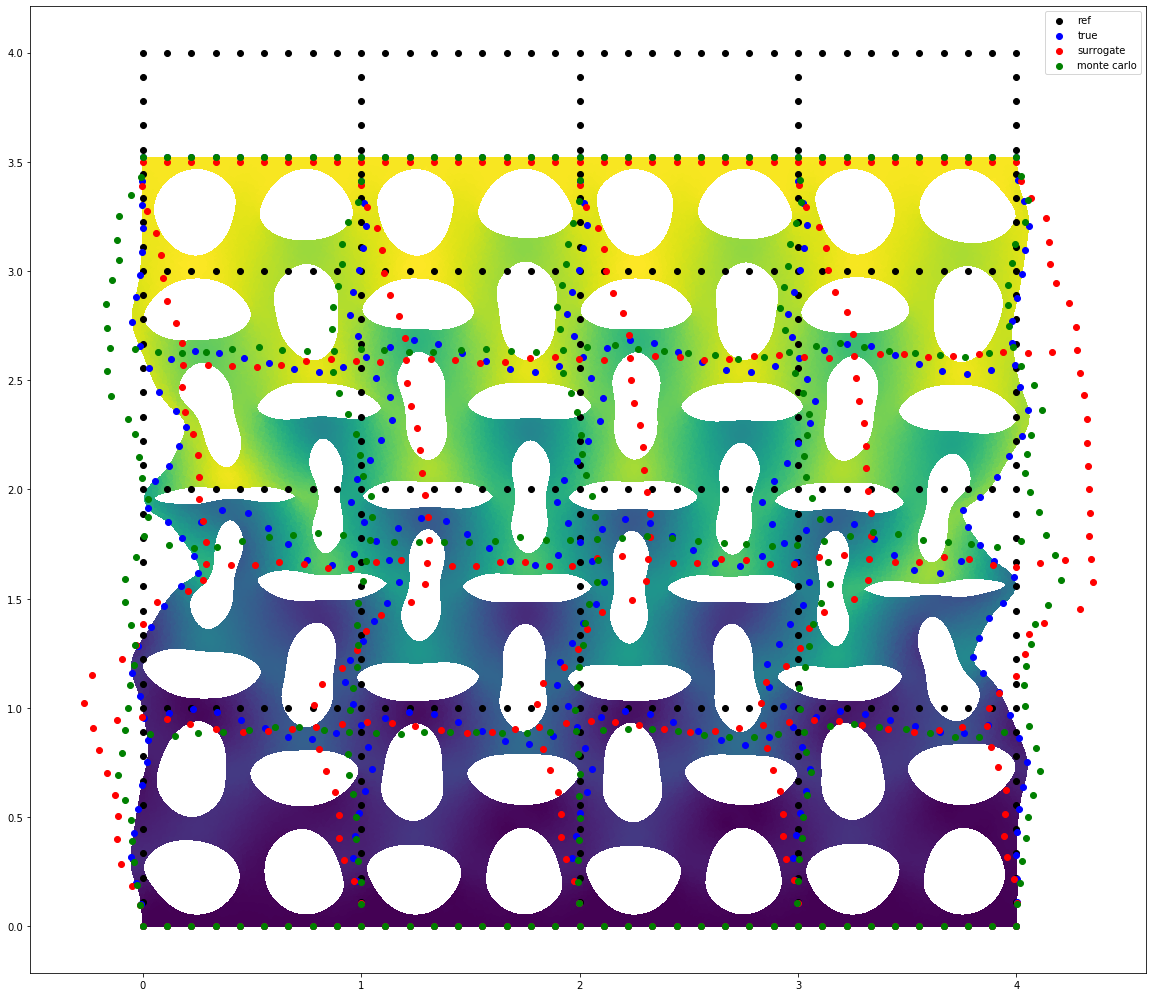

In [72]:
plt.figure(figsize=(20,20))
fa.plot(true_soln, mode='displacement')
plt.scatter(initial_coords[:, 0], initial_coords[:, 1], color='k', label='ref')
plt.scatter(true_final_coords[:, 0], true_final_coords[:, 1], color='b', label='true')
plt.scatter(surr_final_coords[:, 0], surr_final_coords[:, 1], color='r', label='surrogate')
plt.scatter(mc_final_coords[:, 0], mc_final_coords[:, 1], color='g', label='monte carlo')
plt.legend()
plt.show()

In [ ]:
fsm2 = FunctionSpaceMap(pde.V, 5, cuda=True)



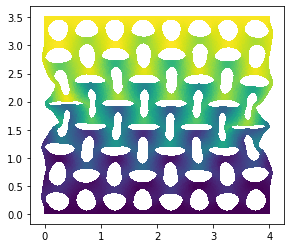

In [47]:
fa.plot(true_soln, mode='displacement')

In [73]:


print(cem.energy(surr_soln, params, None))
print(cem.energy(cand_soln, params, None))
print(cem.energy(torch.Tensor(true_final_coords - initial_coords).cuda(), params, None))
print(cem.energy(boundary_data.cuda(), params, None))
print(cfem.pde.energy(true_soln))

tensor(0.0418, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0506, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
0.04128755661625623


In [81]:
params = torch.autograd.Variable(params, requires_grad=True)
print(cem.energy(surr_soln, params, None))
print(torch.autograd.grad(cem.energy(surr_soln, params, None), params))


tensor(0.0418, device='cuda:0', grad_fn=<SumBackward0>)
(tensor([[ 0.0012,  0.0023],
        [-0.0012,  0.0078],
        [ 0.0003,  0.0021],
        [ 0.0007,  0.0020],
        [ 0.0010,  0.0025],
        [-0.0004,  0.0080],
        [ 0.0005,  0.0017],
        [ 0.0008,  0.0028],
        [ 0.0009,  0.0023],
        [-0.0004,  0.0079],
        [ 0.0004,  0.0017],
        [ 0.0009,  0.0033],
        [ 0.0006,  0.0024],
        [-0.0013,  0.0080],
        [ 0.0002,  0.0013],
        [ 0.0006,  0.0037]]),)


In [30]:
from src.energy_model.fenics_energy_model import FenicsEnergyModel

fem = FenicsEnergyModel(args, pde, fsm)

In [34]:
surr_cell_coords = torch.matmul(
    cem.cell_maps.view(-1, cem.cell_maps.size(2)), surr_soln
).view(cem.n_cells, -1, 2)

true_cell_coords = torch.matmul(
    cem.cell_maps.view(-1, cem.cell_maps.size(2)), torch.Tensor(true_final_coords - initial_coords).cuda()
).view(cem.n_cells, -1, 2)

In [61]:
from src.geometry.remove_rigid_body import RigidRemover
rigid_remover = RigidRemover(fsm)

data_minimizers = []
us = torch.stack([ckpt['traindata'][i][0] for i in range(len(ckpt['traindata']))])
us = fsm.to_ring(rigid_remover(us))

true_cell_coords = rigid_remover(true_cell_coords)
for i in range(len(true_cell_coords)):
    dists = (
        (true_cell_coords[i].unsqueeze(0) - us)**2).sum(dim=2).sum(dim=1).data.cpu().numpy()
    data_minimizers.append(np.argmin(dists))

In [82]:
torch.save(true_cell_coords, 'true_cell_coords.pt')

In [62]:
data_minimizers

[53842,
 10086,
 20229,
 88865,
 19715,
 234757,
 255194,
 51849,
 19715,
 27806,
 234757,
 19715,
 237372,
 38325,
 10086,
 19171]

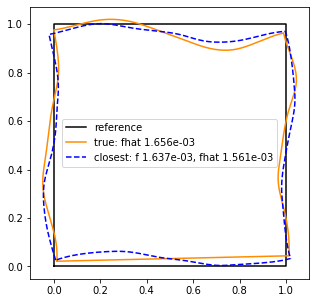

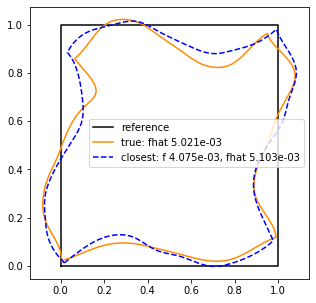

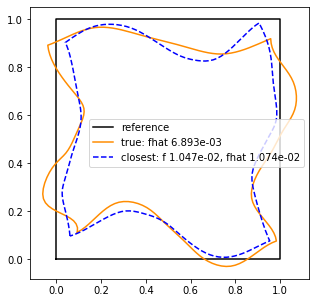

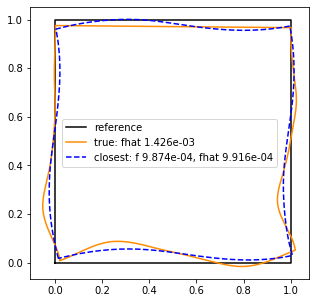

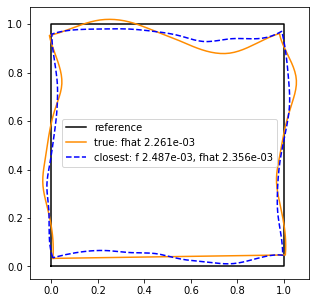

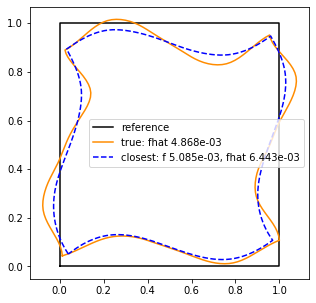

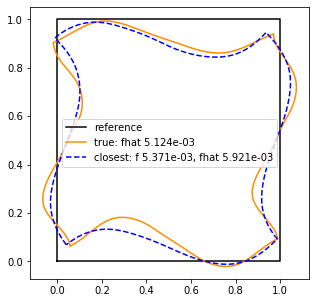

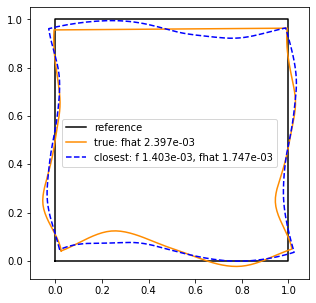

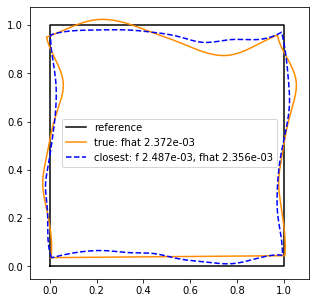

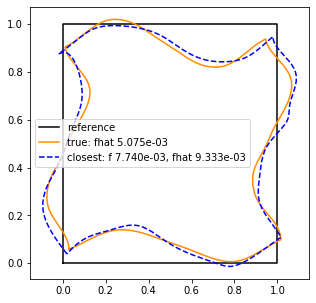

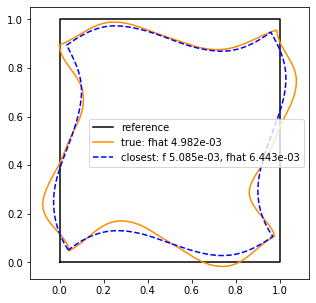

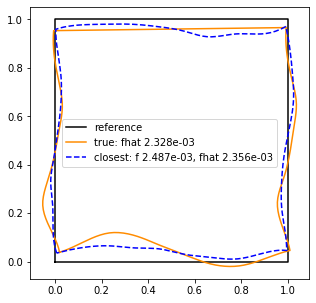

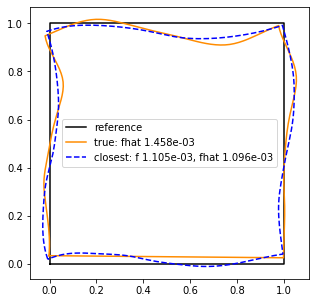

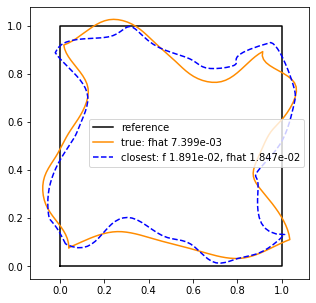

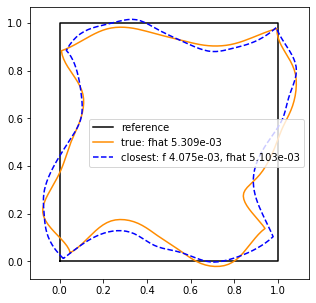

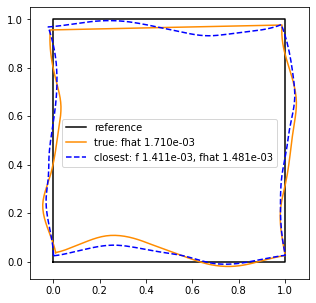

In [80]:
from src.viz.plotting import plot_boundary

for i in range(len(data_minimizers)): 
    plt.figure(figsize=(5,5))
    plot_boundary(
        lambda x: (0, 0),
        200,
        label="reference",
        color="k",
    )
    plot_boundary(
        fsm.get_query_fn(true_cell_coords[i]),
        200,
        label="true: fhat {:.3e}".format(
            sem.f(true_cell_coords[i].unsqueeze(0), params[0].unsqueeze(0),
                  None).data.cpu().numpy().sum()),
        linestyle="-",
        color="darkorange",
    )
    plot_boundary(
        fsm.get_query_fn(us[data_minimizers[i]]
        ),
        200,
        label="closest: f {:.3e}, fhat {:.3e}".format(
            ckpt['traindata'][data_minimizers[i]][2].data.cpu().numpy().sum(),
            sem.f(us[data_minimizers[i]].unsqueeze(0), params[0].unsqueeze(0),
                  None).data.cpu().numpy().sum()),
        linestyle="--",
        color="blue",
    )
    plt.legend()
    plt.show()

In [100]:
check_u

tensor([[ 0.0145,  0.0170],
        [ 0.0123,  0.0400],
        [ 0.0124,  0.0533],
        [ 0.0108,  0.0556],
        [ 0.0094,  0.0474],
        [ 0.0102,  0.0326],
        [ 0.0101,  0.0189],
        [ 0.0091,  0.0112],
        [ 0.0079,  0.0136],
        [ 0.0068,  0.0293],
        [-0.0172,  0.0216],
        [-0.0288,  0.0155],
        [-0.0314,  0.0098],
        [-0.0228,  0.0032],
        [-0.0082, -0.0022],
        [ 0.0064, -0.0071],
        [ 0.0134, -0.0135],
        [ 0.0103, -0.0194],
        [-0.0041, -0.0267],
        [-0.0029, -0.0409],
        [-0.0018, -0.0440],
        [-0.0027, -0.0369],
        [-0.0005, -0.0237],
        [-0.0008, -0.0080],
        [ 0.0006,  0.0007],
        [ 0.0002, -0.0025],
        [ 0.0017, -0.0159],
        [ 0.0039, -0.0393],
        [ 0.0187, -0.0305],
        [ 0.0206, -0.0256],
        [ 0.0125, -0.0198],
        [-0.0006, -0.0141],
        [-0.0153, -0.0091],
        [-0.0236, -0.0031],
        [-0.0221,  0.0026],
        [-0.0089,  0

In [110]:
from src.arguments import parser
from src import fa_combined as fa
from src.pde.metamaterial import Metamaterial
from src.maps.function_space_map import FunctionSpaceMap
from src.nets.feed_forward_net import FeedForwardNet
from src.energy_model.fenics_energy_model import FenicsEnergyModel
from src.energy_model.surrogate_energy_model import SurrogateEnergyModel
from src.energy_model.composed_energy_model import ComposedEnergyModel
from src.energy_model.composed_fenics_energy_model import ComposedFenicsEnergyModel

pde = Metamaterial(args)
fsm = FunctionSpaceMap(pde.V, args.bV_dim)
fem = FenicsEnergyModel(args, pde, fsm)
print(args.bV_dim)
print(fsm.vector_dim)
check_u = us[data_minimizers[3]]
print(fsm.to_torch(check_u.cpu()).shape)
print(check_u.shape)
print(fem.f_J(torch.zeros(72)))

10
72
torch.Size([72])
torch.Size([36, 2])


AttributeError: 'float' object has no attribute '_cpp_object'

In [ ]:
print(fem.f(boundary_fn))

In [91]:
check_u = us[data_minimizers[3]]
print(check_u.shape)
for i in range(10):
    print(i)
    boundary_fn = fem.fsm.to_V(check_u)
    f = fem.f(boundary_fn)
    JV = fa.compute_gradient(f, fa.Control(boundary_fn))
    J = fem.fsm.to_ring(JV)
    check_u = check_u - 1.0 * (J + check_u - true_cell_coords[2])
    plt.figure(figsize=(5,5))
    plot_boundary(
        lambda x: (0, 0),
        200,
        label="reference",
        color="k",
    )
    plot_boundary(
        fsm.get_query_fn(true_cell_coords[3]),
        200,
        label="true: fhat {:.3e}".format(
            sem.f(true_cell_coords[3].unsqueeze(0), params[0].unsqueeze(0),
                  None).data.cpu().numpy().sum()),
        linestyle="-",
        color="darkorange",
    )
    plot_boundary(
        fsm.get_query_fn(us[data_minimizers[3]]
        ),
        200,
        label="closest: f {:.3e}, fhat {:.3e}".format(
            ckpt['traindata'][data_minimizers[3]][2].data.cpu().numpy().sum(),
            sem.f(us[data_minimizers[3]].unsqueeze(0), params[0].unsqueeze(0),
                  None).data.cpu().numpy().sum()),
        linestyle="--",
        color="blue",
    )
    plot_boundary(
    fsm.get_query_fn(true_cell_coords[3]),
    200,
    label="check_u: fhat {:.3e}".format(
        sem.f(check_u.unsqueeze(0), params[0].unsqueeze(0),
              None).data.cpu().numpy().sum()),
    linestyle="-",
    color="green",
    )
    plt.legend()
    plt.show()

torch.Size([36, 2])
0


AttributeError: 'float' object has no attribute '_cpp_object'

In [64]:
print(torch.mean((us**2).sum(dim=2).sum(dim=1)))
print(torch.std((us**2).sum(dim=2).sum(dim=1)))

print(torch.mean((true_cell_coords**2).sum(dim=2).sum(dim=1)))
print(torch.std((true_cell_coords**2).sum(dim=2).sum(dim=1)))


tensor(0.1578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3120, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.1984, device='cuda:0')
tensor(0.1417, device='cuda:0')


In [24]:
logs1 = net(fsm.to_torch(torch.matmul(
      cem.cell_maps.view(-1, cem.cell_maps.size(2)),
      surr_soln).view(cem.n_cells, -1, 2)),
    params.cuda())

In [25]:
logs2 = net(fsm.to_torch(torch.matmul(
      cem.cell_maps.view(-1, cem.cell_maps.size(2)),
      torch.Tensor(true_final_coords-initial_coords).cuda()).view(cem.n_cells, -1, 2)),
    params.cuda())

In [26]:
logs1 - logs2

tensor([[-0.4418],
        [-1.4253],
        [-0.1721],
        [-1.0433],
        [-0.1951],
        [-1.2420],
        [-0.2592],
        [-1.0532],
        [ 0.0699],
        [-1.2153],
        [-0.2950],
        [-1.1627],
        [ 0.1317],
        [-1.3984],
        [-0.1723],
        [-1.0765]], device='cuda:0', grad_fn=<SubBackward0>)

In [27]:
logs1

tensor([[-4.0390],
        [-5.5476],
        [-4.2521],
        [-4.6076],
        [-3.7723],
        [-5.3210],
        [-4.2870],
        [-4.6122],
        [-3.5298],
        [-5.2903],
        [-4.3040],
        [-4.6869],
        [-3.4480],
        [-5.4467],
        [-4.1661],
        [-4.6311]], device='cuda:0', grad_fn=<ViewBackward>)